##Import library

In [33]:
!pip install sastrawi

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# NLP Preprocessing
import re
import string
import csv
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ulasan_gopay.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0cae73fc-8b80-485c-8185-71930ca9902e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya suka gopay karena murah dan saldo tetap a...,2,43,1.44.0,2025-04-07 12:28:24,"Mohon maaf, Kak Cipta. Agar bisa menggunakan G...",2025-04-07 15:47:08,1.44.0
1,feed408f-01f8-4da6-bbd3-13aab4747d7c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,GoPay emang terbaik! Banyak banget promo dan c...,5,95,1.45.0,2025-04-08 01:23:41,NaN,NaN,1.45.0
2,5e295fec-8e3b-4084-bceb-9289f0c6e2b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",1,600,1.44.0,2025-03-31 08:40:12,"Hai Kak Charis, pastikan nomor tujuan sudah be...",2025-03-31 09:25:18,1.44.0
3,a38f0670-9576-48ae-964f-945cda28eb80,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi bagus untuk transaksi, tapi untuk bag...",4,10,1.45.0,2025-04-07 10:50:25,"Hai Kak Ghazali, mohon maaf atas ketidaknyaman...",2025-04-07 10:48:04,1.45.0
4,09e59012-2ca2-4c54-9410-e8d5401ac655,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Geblek nih gopay, saya isi mandiri emoney tran...",1,25,1.45.0,2025-04-07 16:01:21,"Hai Kak Iin, mohon maat atas ketidaknyamananny...",2025-04-07 16:15:00,1.45.0


In [ ]:
#hanya memakai kolom "content"
content_df= df[['content']].copy()
content_df.head()

,content
0,saya suka gopay karena murah dan saldo tetap a...
1,GoPay emang terbaik! Banyak banget promo dan c...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ..."
3,"Aplikasi bagus untuk transaksi, tapi untuk bag..."
4,"Geblek nih gopay, saya isi mandiri emoney tran..."


In [ ]:
len(content_df)

187695

Terdapat 187695 data

In [ ]:
content_df.isna().sum()

,0
content,1


Ada 1 nilai yang bersifat null

In [ ]:
content_df.dropna(inplace=True)
content_df.isna().sum()

,0
content,0


In [ ]:
content_df.duplicated().sum()

np.int64(71120)

Terdapat 71120 data yang terduplikat

In [ ]:
content_df.drop_duplicates(inplace=True)
content_df.duplicated().sum()

np.int64(0)

In [ ]:
len(content_df)

116574

Setelah menghapus nilai duplikat, data berkurang dari 187695 menjadi 116574

##Data Preprocessing

In [ ]:
# Membersihkan teks dari mention, hashtag, RT, link, angka, dan karakter khusus serta menormalkan spasi dan menghapus tanda baca
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

# Mengubah semua teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Memecah teks menjadi token-token kata
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Menghapus stopwords (kata-kata umum yang tidak signifikan) dalam bahasa Indonesia dan Inggris, serta beberapa kata tambahan
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Mengubah kata-kata menjadi bentuk kata dasar menggunakan stemmer Bahasa Indonesia
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [ ]:
slang_dict = {
    "@": "di",
    "abis": "habis",
    "wtb": "beli",
    "masi": "masih",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "maks": "maksimal",
    "min": "minimal",
    "apk": "aplikasi",
    "app": "aplikasi",
    "ga": "tidak",
    "gk": "tidak",
    "gak": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "bener": "benar",
    "parah": "buruk",
    "mantul": "mantap betul",
    "kyk": "seperti",
    "udh": "sudah",
    "udah": "sudah",
    "lgsung": "langsung",
    "langsuung": "langsung",
    "bisa2nya": "bisa bisanya",
    "trus": "terus",
    "nabung": "menabung",
    "transferan": "transfer",
    "atm": "mesin atm",
    "gagal": "tidak berhasil",
    "lemot": "lambat",
    "ribet": "sulit",
    "ngulang": "mengulang",
    "ngebug": "terjadi bug",
    "ngehang": "hang",
    "fitur2": "fitur-fitur",
    "gausah": "tidak usah",
    "ga bisa": "tidak bisa",
    "ngebantu": "membantu",
    "susah": "sulit",
    "oke": "baik",
    "ok": "baik",
    "yg": "yang",
    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "kece": "bagus",
    "mager": "malas gerak",
    "sinyalnya": "sinyal",
    "login2": "login",
    "error2": "error",
    "auto": "otomatis",
    "sgt": "sangat",
    "tf": "transfer",
    "updt": "update",
    "apdet": "update",
    "donlod": "download",
    "lg": "lagi",
    "jg": "juga",
    "trs": "terus",
    "sy": "saya",
    "bls": "balas",
    "gpp": "tidak apa-apa",
    "gapapa": "tidak apa-apa",
    "pgn": "ingin",
    "pengen": "ingin",
    "klo": "kalau",
    "kl": "kalau",
    "lbh": "lebih",
    "skrg": "sekarang",
    "bkn": "bukan",
    "gmn": "bagaimana",
    "org": "orang",
    "krn": "karena",
    "bru": "baru",
    "dr": "dari",
    "tlg": "tolong",
    "sm": "sama",
    "dpt": "dapat",
    "utk": "untuk",
    "byk": "banyak",
    "sblm": "sebelum",
    "hrs": "harus",
    "cb": "coba",
    "bnr": "benar",
    "kt": "kata",
    "kpn": "kapan",
    "gw": "saya",
    "gue": "saya",
    "gua": "saya",
    "lo": "kamu",
    "lu": "kamu",
    "loe": "kamu",
    "bs": "bisa",
    "jgn": "jangan",
    "tp": "tapi",
    "mnrt": "menurut",
    "bgmn": "bagaimana",
    "dlu": "dulu",
    "blm": "belum",
    "sih": "saja",
    "nih": "ini",
    "tuh": "itu",
    "dll": "dan lain-lain",
    "dsb": "dan sebagainya",
    "fb": "facebook",
    "ig": "instagram",
    "twit": "twitter",
    "tw": "twitter",
    "x": "twitter",
    "yt": "youtube",
    "otw": "sedang dalam perjalanan",
    "pm": "pesan langsung",
    "dm": "pesan langsung",
    "fyp": "for your page",
    "tik": "tiktok",
    "kzl": "kesal",
    "gapapa": "tidak apa-apa",
    "ml": "mobile legends",
    "pubg": "playerunknown's battlegrounds",
    "ff": "free fire",
}

In [ ]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slang_dict:
            fixed_words.append(slang_dict[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
content_df_clean = content_df.copy() #copy content_df ke content_df_clean



In [ ]:
content_df_clean['text_clean'] = content_df_clean['content'].apply(cleanText)
content_df_clean['text_casefoldingText'] = content_df_clean['text_clean'].apply(casefoldingText)
content_df_clean['text_slangwords'] = content_df_clean['text_casefoldingText'].apply(fix_slangwords)
content_df_clean['text_tokenizingText'] = content_df_clean['text_slangwords'].apply(tokenizingText)
content_df_clean['text_stopword'] = content_df_clean['text_tokenizingText'].apply(filteringText)
content_df_clean['text_akhir'] = content_df_clean['text_stopword'].apply(toSentence)

In [ ]:
content_df_clean.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,"[gopay, emang, terbaik, banyak, banget, promo,...","[gopay, emang, terbaik, banget, promo, cashbac...",gopay emang terbaik banget promo cashback biki...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk nunggu h...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, nunggu, harikalo, ...",kecewa top masuk masuk nunggu harikalo info ke...
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,...",aplikasi bagus transaksi transfer tolong sedia...
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek ini gopay saya isi mandiri emoney trans...,"[geblek, ini, gopay, saya, isi, mandiri, emone...","[geblek, gopay, isi, mandiri, emoney, transaks...",geblek gopay isi mandiri emoney transaksi suks...


##Pelabelan

In [ ]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    else:
      polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [ ]:
results = content_df_clean['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
content_df_clean['polarity_score'] = results[0]
content_df_clean['polarity'] = results[1]
print(content_df_clean['polarity'].value_counts())

polarity
positive    54248
negative    36004
neutral     26322
Name: count, dtype: int64


Menghasilkan 3 kelas polarity

In [ ]:
content_df_clean.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...,8,positive
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,"[gopay, emang, terbaik, banyak, banget, promo,...","[gopay, emang, terbaik, banget, promo, cashbac...",gopay emang terbaik banget promo cashback biki...,15,positive
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk nunggu h...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, nunggu, harikalo, ...",kecewa top masuk masuk nunggu harikalo info ke...,-9,negative
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,...",aplikasi bagus transaksi transfer tolong sedia...,-1,negative
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek ini gopay saya isi mandiri emoney trans...,"[geblek, ini, gopay, saya, isi, mandiri, emone...","[geblek, gopay, isi, mandiri, emoney, transaks...",geblek gopay isi mandiri emoney transaksi suks...,-26,negative


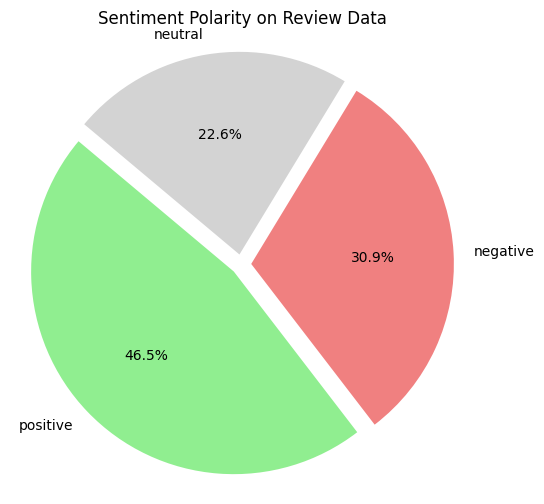

In [ ]:
# Hitung jumlah masing-masing kelas
polarity_counts = content_df_clean['polarity'].value_counts()

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(polarity_counts,
        labels=polarity_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightgreen', 'lightcoral', 'lightgray'],
        explode=(0.05, 0.05, 0.05))  # Biar semua slice sedikit "meledak" keluar

plt.title('Sentiment Polarity on Review Data')
plt.axis('equal')  # Biar pie-nya bulat
plt.show()

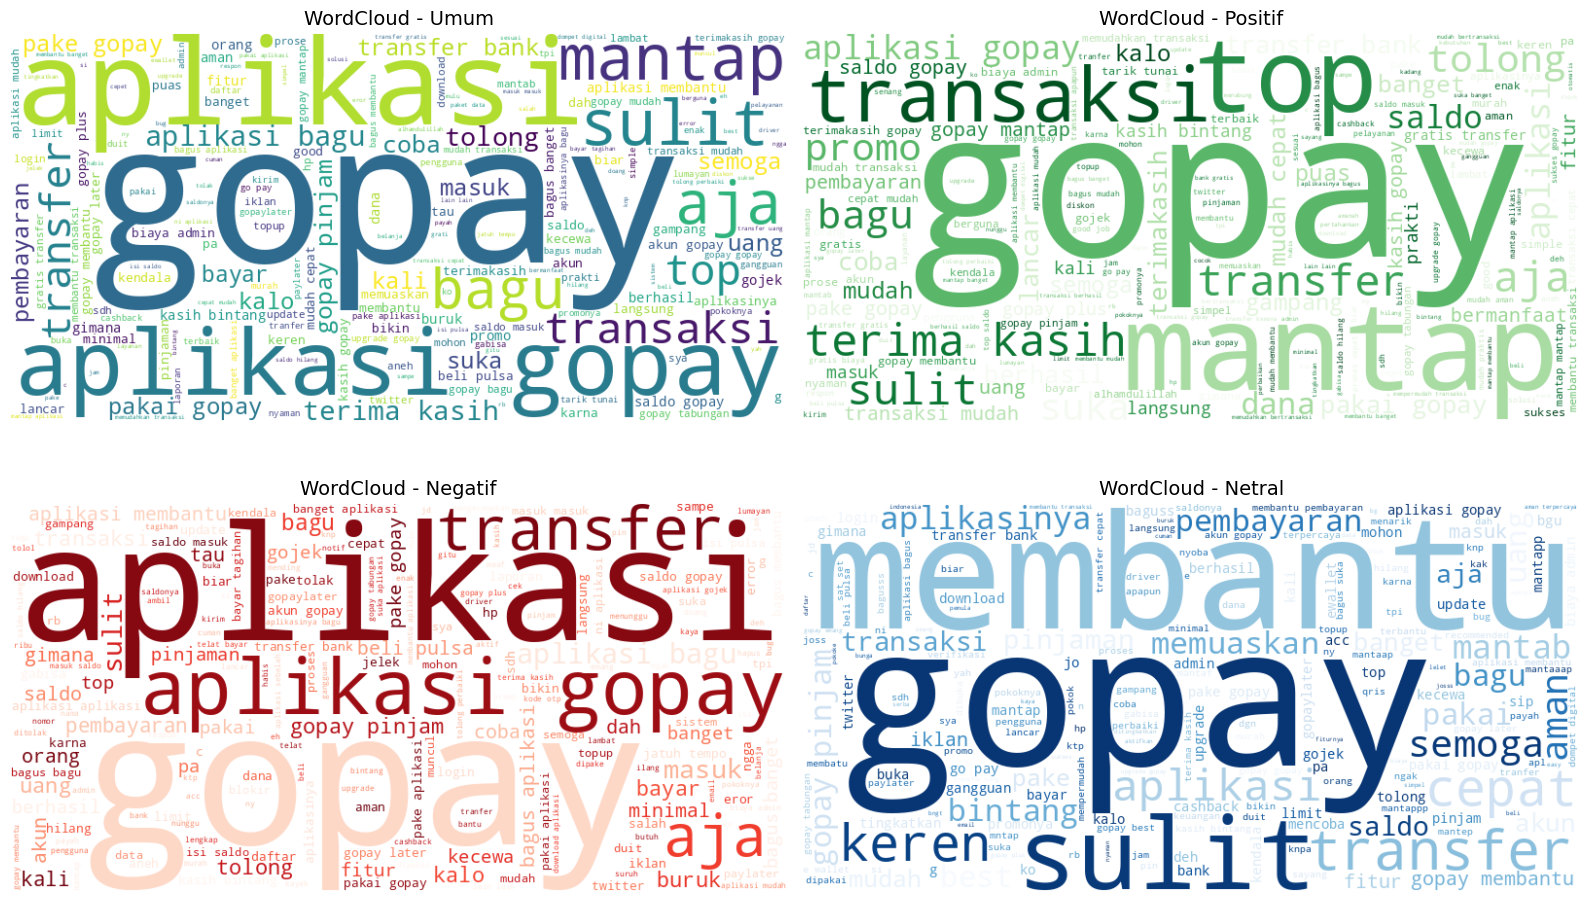

In [ ]:
from wordcloud import WordCloud
# Fungsi untuk menggabungkan teks berdasarkan label polaritas
def gabungkan_teks(dataframe, polaritas=None):
    if polaritas:
        kumpulan = dataframe[dataframe['polarity'] == polaritas]['text_stopword']
    else:
        kumpulan = dataframe['text_stopword']
    return " ".join(" ".join(baris) for baris in kumpulan)

# Kumpulkan teks untuk masing-masing kategori
teks_semua = gabungkan_teks(content_df_clean)
teks_pos = gabungkan_teks(content_df_clean, 'positive')
teks_neg = gabungkan_teks(content_df_clean, 'negative')
teks_net = gabungkan_teks(content_df_clean, 'neutral')

# Konfigurasi umum WordCloud
pengaturan_wc = {
    'width': 800,
    'height': 400,
    'background_color': 'white'
}

# Buat WordCloud untuk masing-masing kategori
wordclouds = {
    'Umum': WordCloud(**pengaturan_wc).generate(teks_semua),
    'Positif': WordCloud(**pengaturan_wc, colormap='Greens').generate(teks_pos),
    'Negatif': WordCloud(**pengaturan_wc, colormap='Reds').generate(teks_neg),
    'Netral': WordCloud(**pengaturan_wc, colormap='Blues').generate(teks_net),
}

# Tampilkan dalam layout 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
judul = list(wordclouds.keys())
indeks_axes = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, label in enumerate(judul):
    baris, kolom = indeks_axes[i]
    axes[baris, kolom].imshow(wordclouds[label], interpolation='bilinear')
    axes[baris, kolom].set_title(f"WordCloud - {label}", fontsize=14)
    axes[baris, kolom].axis('off')

plt.tight_layout()
plt.show()

##Skema 1 Logistic Regression + TF-IDF dengan split 75/25

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Fitur dan Label
x = content_df_clean['text_akhir']
y = content_df_clean['polarity']

# Split data (75% train, 25% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Model Logistic Regression
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(x_train_tfidf, y_train)

# Prediksi dan akurasi
y_train_pred = model_lr.predict(x_train_tfidf)
y_test_pred = model_lr.predict(x_test_tfidf)

accuracy_train_lr = accuracy_score(y_train, y_train_pred)
accuracy_test_lr = accuracy_score(y_test, y_test_pred)

# Output hasil
print(f'Logistic Regression + TF-IDF (Train Accuracy): {round(accuracy_train_lr * 100, 2)}%')
print(f'Logistic Regression + TF-IDF (Test Accuracy): {round(accuracy_test_lr * 100, 2)}%')

Logistic Regression + TF-IDF (Train Accuracy): 95.6%
Logistic Regression + TF-IDF (Test Accuracy): 93.23%


Classification Report (Logistic Regression + TF-IDF):
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93      9001
     neutral       0.90      0.87      0.88      6581
    positive       0.95      0.96      0.96     13562

    accuracy                           0.93     29144
   macro avg       0.93      0.92      0.92     29144
weighted avg       0.93      0.93      0.93     29144



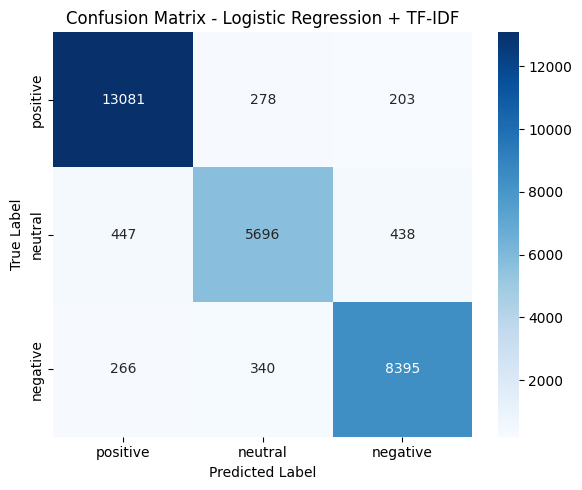

In [ ]:
# Classification report
print("Classification Report (Logistic Regression + TF-IDF):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['positive', 'neutral', 'negative'])

# Visualisasi
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.title("Confusion Matrix - Logistic Regression + TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

##Skema 2 Support Vector Machine(SVM) + CountVectorizer dengan split data 80/20

In [ ]:
from sklearn.svm import LinearSVC #LinearSVC cocok untuk data teks dengan dimensi tinggi
from sklearn.feature_extraction.text import CountVectorizer


#Fitur dan label
x = content_df_clean['text_akhir']
y = content_df_clean['polarity']

# Split data: 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# CountVectorizer dengan batasan jumlah fitur agar efisien
vectorizer = CountVectorizer(max_features=5000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# Model SVM dengan LinearSVC
model_svm = LinearSVC()
model_svm.fit(x_train_vec, y_train)

# Prediksi
y_train_pred = model_svm.predict(x_train_vec)
y_test_pred = model_svm.predict(x_test_vec)

# Akurasi
accuracy_train_svm = accuracy_score(y_train, y_train_pred)
accuracy_test_svm = accuracy_score(y_test, y_test_pred)

# Output akurasi
print(f'LinearSVC + CountVectorizer (Train Accuracy): {round(accuracy_train_svm * 100, 2)}%')
print(f'LinearSVC + CountVectorizer (Test Accuracy): {round(accuracy_test_svm * 100, 2)}%')

LinearSVC + CountVectorizer (Train Accuracy): 96.85%
LinearSVC + CountVectorizer (Test Accuracy): 94.99%



Classification Report (LinearSVC + CountVectorizer):
              precision    recall  f1-score   support

    negative       0.94      0.97      0.95      7201
     neutral       0.93      0.87      0.90      5264
    positive       0.96      0.98      0.97     10850

    accuracy                           0.95     23315
   macro avg       0.95      0.94      0.94     23315
weighted avg       0.95      0.95      0.95     23315



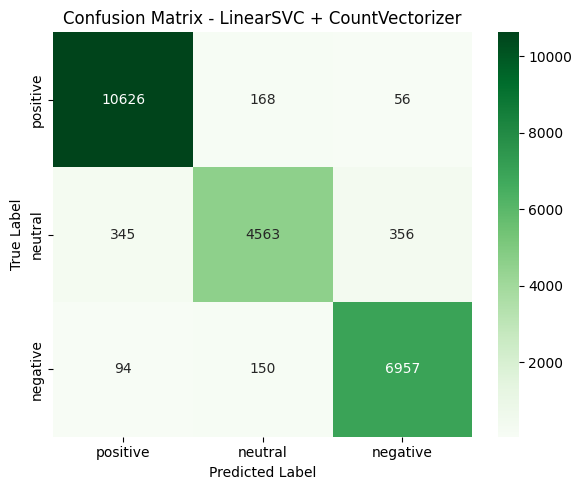

In [ ]:
# Classification report
print("\nClassification Report (LinearSVC + CountVectorizer):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred, labels=['positive', 'neutral', 'negative'])

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.title("Confusion Matrix - LinearSVC + CountVectorizer")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

##Skema 3 Random Forest + TF-IDF dengan split data 75/25

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Fitur dan label
x = content_df_clean['text_akhir']
y = content_df_clean['polarity']

# Split data: 75% training, 25% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# Model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(x_train_vec, y_train)

# Prediksi
y_train_pred = model_rf.predict(x_train_vec)
y_test_pred = model_rf.predict(x_test_vec)

# Akurasi
accuracy_train_rf = accuracy_score(y_train, y_train_pred)
accuracy_test_rf = accuracy_score(y_test, y_test_pred)

# Output akurasi
print(f'Random Forest + TF-IDF (Train Accuracy): {round(accuracy_train_rf * 100, 2)}%')
print(f'Random Forest + TF-IDF (Test Accuracy): {round(accuracy_test_rf * 100, 2)}%')

Random Forest + TF-IDF (Train Accuracy): 99.72%
Random Forest + TF-IDF (Test Accuracy): 90.44%



Classification Report (Random Forest + TF-IDF):
              precision    recall  f1-score   support

    negative       0.88      0.89      0.88      9001
     neutral       0.93      0.87      0.90      6581
    positive       0.91      0.93      0.92     13562

    accuracy                           0.90     29144
   macro avg       0.91      0.90      0.90     29144
weighted avg       0.90      0.90      0.90     29144



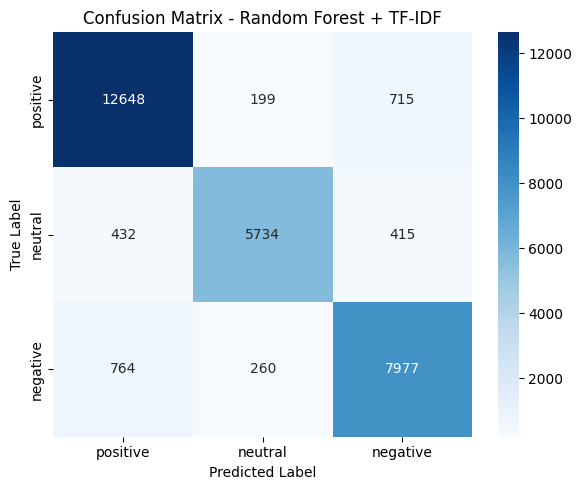

In [38]:
# Classification report
print("\nClassification Report (Random Forest + TF-IDF):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred, labels=['positive', 'neutral', 'negative'])

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.title("Confusion Matrix - Random Forest + TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

##Skema 4 LSTM + Tokenizer dengan split data 70/30

In [39]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(content_df_clean['polarity'])

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(content_df_clean['text_akhir'])

# Konversi teks jadi urutan angka
sequences = tokenizer.texts_to_sequences(content_df_clean['text_akhir'])
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Train-Test Split (70:30)
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(padded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Arsitektur model LSTM
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: positive, neutral, negative
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training model
history = model.fit(x_train_dl, y_train_dl, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluasi
y_pred_dl = model.predict(x_test_dl)
y_pred_labels = y_pred_dl.argmax(axis=1)

# Akurasi
accuracy_train_dl = history.history['accuracy'][-1]
accuracy_test_dl = accuracy_score(y_test_dl, y_pred_labels)

print(f'Deep Learning (LSTM) (Train Accuracy): {round(accuracy_train_dl * 100, 2)}%')
print(f'Deep Learning (LSTM) (Test Accuracy): {round(accuracy_test_dl * 100, 2)}%')

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1020/1020 ━━━━━━━━━━━━━━━━━━━━ 103s 96ms/step - accuracy: 0.4635 - loss: 1.0591 - val_accuracy: 0.4693 - val_loss: 1.0524
Epoch 2/5
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 136s 90ms/step - accuracy: 0.4650 - loss: 1.0559 - val_accuracy: 0.4693 - val_loss: 1.0526
Epoch 3/5
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 140s 88ms/step - accuracy: 0.4678 - loss: 1.0531 - val_accuracy: 0.4693 - val_loss: 1.0531
Epoch 4/5
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 144s 89ms/step - accuracy: 0.4625 - loss: 1.0570 - val_accuracy: 0.4693 - val_loss: 1.0524
Epoch 5/5
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 139s 86ms/step - accuracy: 0.4613 - loss: 1.0572 - val_accuracy: 0.4693 - val_loss: 1.0525
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step
Deep Learning (LSTM) (Train Accuracy): 46.44%
Deep Learning (LSTM) (Test Accuracy): 46.54%


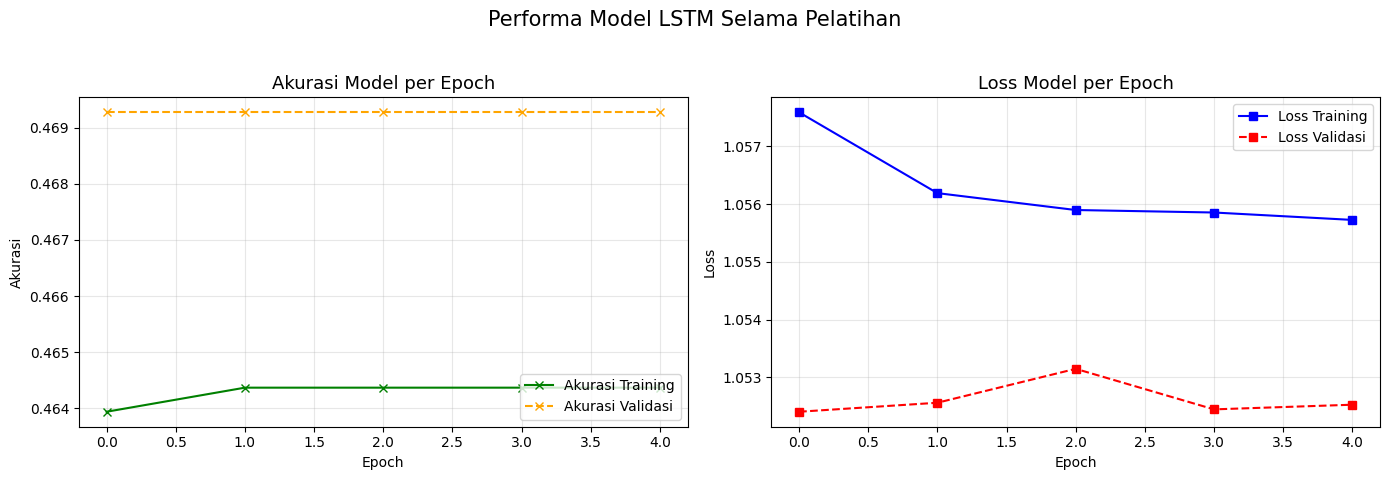

In [40]:
# Visualisasi performa model selama pelatihan
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Akurasi
ax[0].plot(history.history['accuracy'], label='Akurasi Training', color='green', linestyle='-', marker='x')
ax[0].plot(history.history['val_accuracy'], label='Akurasi Validasi', color='orange', linestyle='--', marker='x')
ax[0].set_title('Akurasi Model per Epoch', fontsize=13)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Akurasi')
ax[0].legend(loc='lower right')
ax[0].grid(alpha=0.3)

# Loss
ax[1].plot(history.history['loss'], label='Loss Training', color='blue', linestyle='-', marker='s')
ax[1].plot(history.history['val_loss'], label='Loss Validasi', color='red', linestyle='--', marker='s')
ax[1].set_title('Loss Model per Epoch', fontsize=13)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')
ax[1].grid(alpha=0.3)

plt.suptitle('Performa Model LSTM Selama Pelatihan', fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

####Skema 1: Logistic Regression + TF-IDF (Split 75/25)
Model Logistic Regression yang dipadukan dengan TF-IDF menghasilkan akurasi training sebesar 95.6% dan akurasi testing sebesar 93.23%. Hasil ini menunjukkan bahwa model cukup stabil dan tidak mengalami overfitting. F1-score tertinggi terdapat pada kelas positive (0.96), sementara kelas neutral sedikit lebih menantang dengan f1-score 0.88. Secara keseluruhan, skema ini memberikan hasil yang cukup baik dan dapat dijadikan baseline untuk model pembelajaran mesin.

####Skema 2: Support Vector Machine (LinearSVC) + CountVectorizer (Split 80/20)
Penggunaan LinearSVC dengan fitur dari CountVectorizer menunjukkan performa yang sangat baik dengan akurasi training sebesar 96.85% dan akurasi testing sebesar 94.99%. Kinerja model sangat stabil dan seimbang di semua kelas, dengan f1-score tertinggi pada kelas positive (0.97). Ini menjadikan skema ini sebagai salah satu model yang paling unggul dalam hal presisi dan generalisasi terhadap data uji.



####Skema 3: Random Forest + TF-IDF (Split 75/25)
Model Random Forest memberikan akurasi training yang sangat tinggi, yaitu 99.72%, namun hanya mencapai 90.44% pada data testing. Perbedaan yang cukup signifikan ini menunjukkan bahwa model mengalami overfitting, yaitu terlalu menyesuaikan diri dengan data latih dan kurang general pada data baru. F1-score untuk kelas neutral juga mengalami penurunan meskipun masih cukup layak. Skema ini perlu penyesuaian lebih lanjut agar tidak terlalu overfit.

####Skema 4: LSTM + Tokenizer (Split 70/30)
Skema menggunakan deep learning dengan LSTM menunjukkan performa yang kurang memuaskan, dengan akurasi training hanya 46.44% dan akurasi testing 46.54%. Hal ini menunjukkan bahwa model belum berhasil belajar pola yang baik dari data. Kemungkinan penyebabnya bisa karena preprocessing yang belum optimal, konfigurasi model yang belum tepat, atau keterbatasan dalam jumlah epoch dan tuning parameter. Skema ini memerlukan evaluasi ulang agar dapat menghasilkan model yang lebih efektif.

###Kesimpulan:
Dari keempat skema yang diterapkan, Skema 2 (SVM + CountVectorizer) memberikan performa terbaik dengan keseimbangan antara akurasi tinggi dan kestabilan antar kelas. Skema 1 juga cukup baik sebagai baseline yang kuat. Skema 3 menunjukkan potensi overfitting yang perlu diatasi, sementara Skema 4 (LSTM) masih memerlukan optimasi signifikan agar dapat bersaing dengan model berbasis machine learning lainnya.